In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from datetime import datetime as dt


# Import Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import KNNImputer
from sklearn.feature_selection import chi2

# Import evaluation metric libraries
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

# Import Sampling
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Import preprocessing libraries
from sklearn.preprocessing import StandardScaler

# Import Model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold
import xgboost as xgb

# Import model selection libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load preprocessed data
X_train = pd.read_csv(r'C:\Users\megha\Downloads\project1\data\X_train_processed.csv')
X_test = pd.read_csv(r'C:\Users\megha\Downloads\project1\data\X_test_processed.csv')
y_train = pd.read_csv(r'C:\Users\megha\Downloads\project1\data\y_train.csv').squeeze()
y_test = pd.read_csv(r'C:\Users\megha\Downloads\project1\data\y_test.csv').squeeze()

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle weights and classes 
#classes = y_train.unique()
#weights_dict = dict(pd.Series(y_train).value_counts(normalize=True))

In [3]:
features = X_train.columns


In [4]:
#from imblearn.combine import SMOTETomek

#X_smote, y_smote = SMOTETomek(random_state=0).fit_resample(X_train_scaled, y_train)

#print('Samples in the original dataset: ', len(y_train))
#print('Samples in the resampled dataset: ', len(y_smote))

#y_smote.value_counts().plot(kind='bar', title='Target variable after SMOTE')
#plt.show()

In [5]:
def evaluate_model(model, X_train, X_test, y_train, y_test):

    # fit the model on the training data
    model.fit(X_train, y_train)

    # make predictions on the test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    pred_prob_train = model.predict_proba(X_train)[:,1]
    pred_prob_test = model.predict_proba(X_test)[:,1]

    # calculate ROC AUC score
    roc_auc_train = roc_auc_score(y_train, y_pred_train)
    roc_auc_test = roc_auc_score(y_test, y_pred_test)
    print("\nTrain ROC AUC:", roc_auc_train)
    print("Test ROC AUC:", roc_auc_test)

    # plot the ROC curve
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_prob_train)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_prob_test)
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr_train, tpr_train, label="Train ROC AUC: {:.2f}".format(roc_auc_train))
    plt.plot(fpr_test, tpr_test, label="Test ROC AUC: {:.2f}".format(roc_auc_test))
    plt.legend()
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    # calculate confusion matrix
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    fig, ax = plt.subplots(1, 2, figsize=(11,4))

    print("\nConfusion Matrix:")
    sns.heatmap(cm_train, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='d', ax=ax[0])
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")
    ax[0].set_title("Train Confusion Matrix")

    sns.heatmap(cm_test, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='d', ax=ax[1])
    ax[1].set_xlabel("Predicted Label")
    ax[1].set_ylabel("True Label")
    ax[1].set_title("Test Confusion Matrix")

    plt.tight_layout()
    plt.show()


    # calculate classification report
    cr_train = classification_report(y_train, y_pred_train, output_dict=True)
    cr_test = classification_report(y_test, y_pred_test, output_dict=True)
    print("\nTrain Classification Report:")
    crt = pd.DataFrame(cr_train).T
    print(crt.to_markdown())
    # sns.heatmap(pd.DataFrame(cr_train).T.iloc[:, :-1], annot=True, cmap="Blues")
    print("\nTest Classification Report:")
    crt2 = pd.DataFrame(cr_test).T
    print(crt2.to_markdown())
    # sns.heatmap(pd.DataFrame(cr_test).T.iloc[:, :-1], annot=True, cmap="Blues")

    try:
      try:
        feature_importance = model.feature_importances_
      except:
        feature_importance = model.coef_
      feature_importance = np.absolute(feature_importance)
      if len(feature_importance)==len(features):
        pass
      else:
        feature_importance = feature_importance[0]


      feat = pd.Series(feature_importance, index=features)
      feat = feat.sort_values(ascending=True)
      plt.figure(figsize=(10,6))
      plt.title('Feature Importances for '+str(model), fontsize = 18)
      plt.xlabel('Relative Importance')
      feat.plot(kind='barh', colormap= 'Dark2')
    except AttributeError:
        print("\nThe model does not have feature importances attribute.")

    precision_train = cr_train['weighted avg']['precision']
    precision_test = cr_test['weighted avg']['precision']

    recall_train = cr_train['weighted avg']['recall']
    recall_test = cr_test['weighted avg']['recall']

    acc_train = accuracy_score(y_true = y_train, y_pred = y_pred_train)
    acc_test = accuracy_score(y_true = y_test, y_pred = y_pred_test)

    F1_train = cr_train['weighted avg']['f1-score']
    F1_test = cr_test['weighted avg']['f1-score']

    model_score = [precision_train, precision_test, recall_train, recall_test, acc_train, acc_test, roc_auc_train, roc_auc_test, F1_train, F1_test ]
    return model_score

score = pd.DataFrame(index = ['Precision Train', 'Precision Test','Recall Train','Recall Test','Accuracy Train', 'Accuracy Test','ROC-AUC Train', 'ROC-AUC Test','F1 macro Train', 'F1 macro Test'])

# Logistic Regression 


Train ROC AUC: 0.6570938612857564
Test ROC AUC: 0.6530081831483003


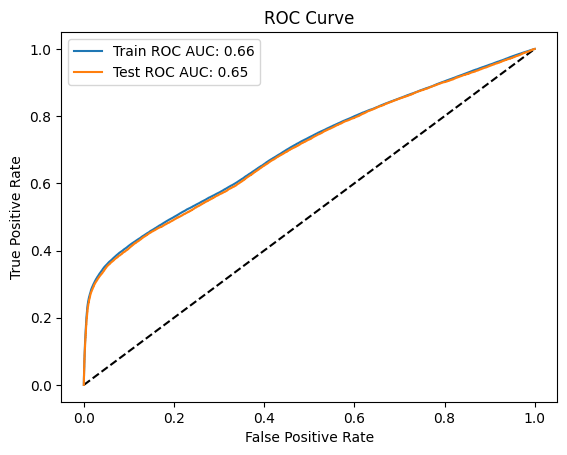


Confusion Matrix:


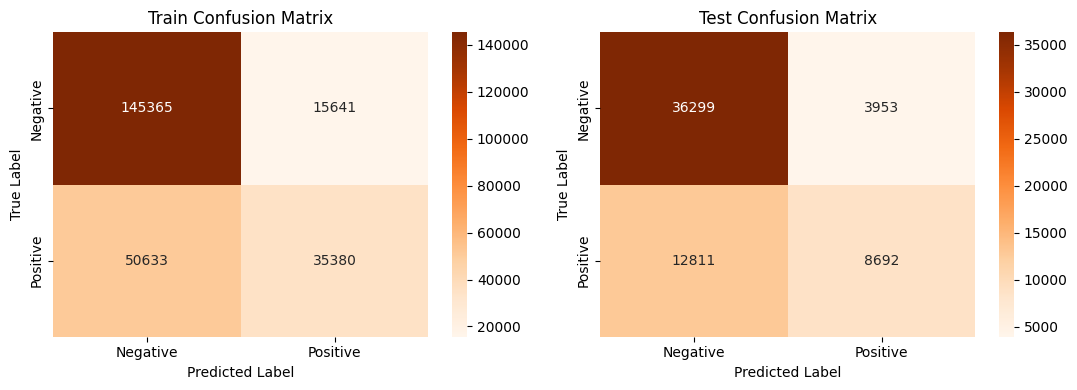


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.741666 | 0.902855 |   0.814361 | 161006        |
| 1            |    0.69344  | 0.411333 |   0.516368 |  86013        |
| accuracy     |    0.731705 | 0.731705 |   0.731705 |      0.731705 |
| macro avg    |    0.717553 | 0.657094 |   0.665364 | 247019        |
| weighted avg |    0.724873 | 0.731705 |   0.710598 | 247019        |

Test Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.739137 | 0.901794 |   0.812403 | 40252       |
| 1            |    0.687386 | 0.404223 |   0.509078 | 21503       |
| accuracy     |    0.72854  | 0.72854  |   0.72854  |     0.72854 |
| macro avg    |    0.713261 | 0.653008 |   0.660741 | 61755       |
| weighted avg |    0.721117 |

,Logistic regression
Precision Train,0.724873
Precision Test,0.721117
Recall Train,0.731705
Recall Test,0.728540
Accuracy Train,0.731705
Accuracy Test,0.728540
ROC-AUC Train,0.657094
ROC-AUC Test,0.653008
F1 macro Train,0.710598
F1 macro Test,0.706786


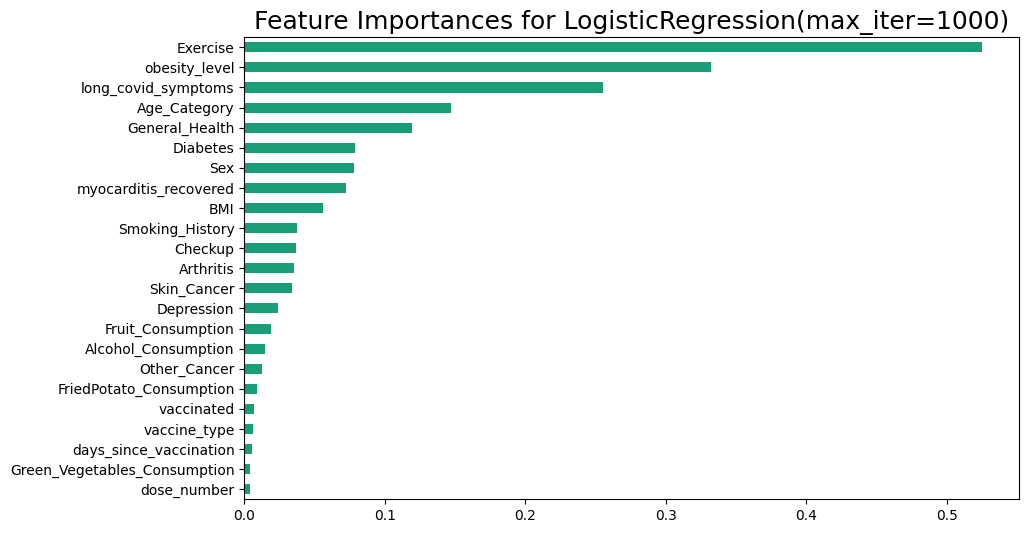

In [6]:
lr_model = LogisticRegression(fit_intercept=True, max_iter=1000)
# Visualizing evaluation Metric Score chart
lr_score = evaluate_model(lr_model, X_train_scaled, X_test_scaled, y_train, y_test) #use scaled data only here

score['Logistic regression'] = lr_score
score

Best hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}

Train ROC AUC: 0.6383087729758213
Test ROC AUC: 0.6335523588039078


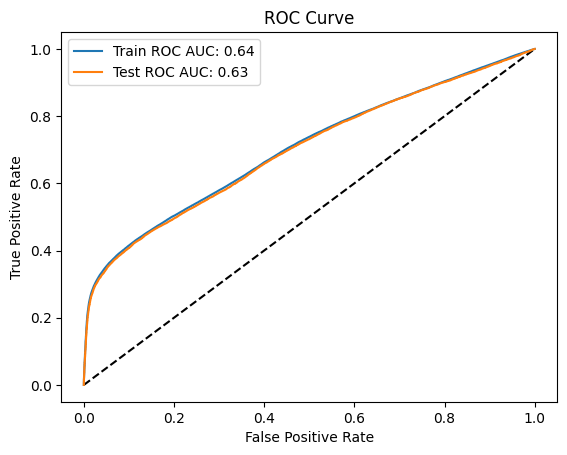


Confusion Matrix:


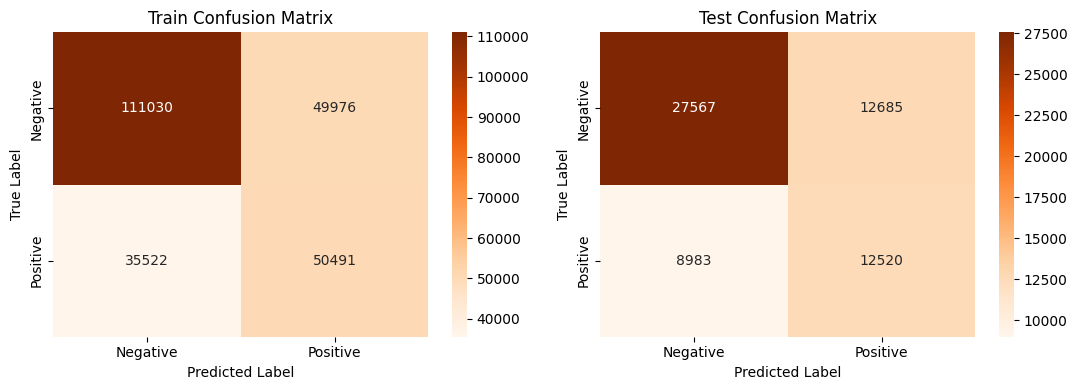


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.757615 | 0.689602 |   0.72201  | 161006        |
| 1            |    0.502563 | 0.587016 |   0.541517 |  86013        |
| accuracy     |    0.653881 | 0.653881 |   0.653881 |      0.653881 |
| macro avg    |    0.630089 | 0.638309 |   0.631763 | 247019        |
| weighted avg |    0.668805 | 0.653881 |   0.659162 | 247019        |

Test Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.754227 | 0.68486  |   0.717872 | 40252       |
| 1            |    0.496727 | 0.582244 |   0.536097 | 21503       |
| accuracy     |    0.64913  | 0.64913  |   0.64913  |     0.64913 |
| macro avg    |    0.625477 | 0.633552 |   0.626984 | 61755       |
| weighted avg |    0.664566 |

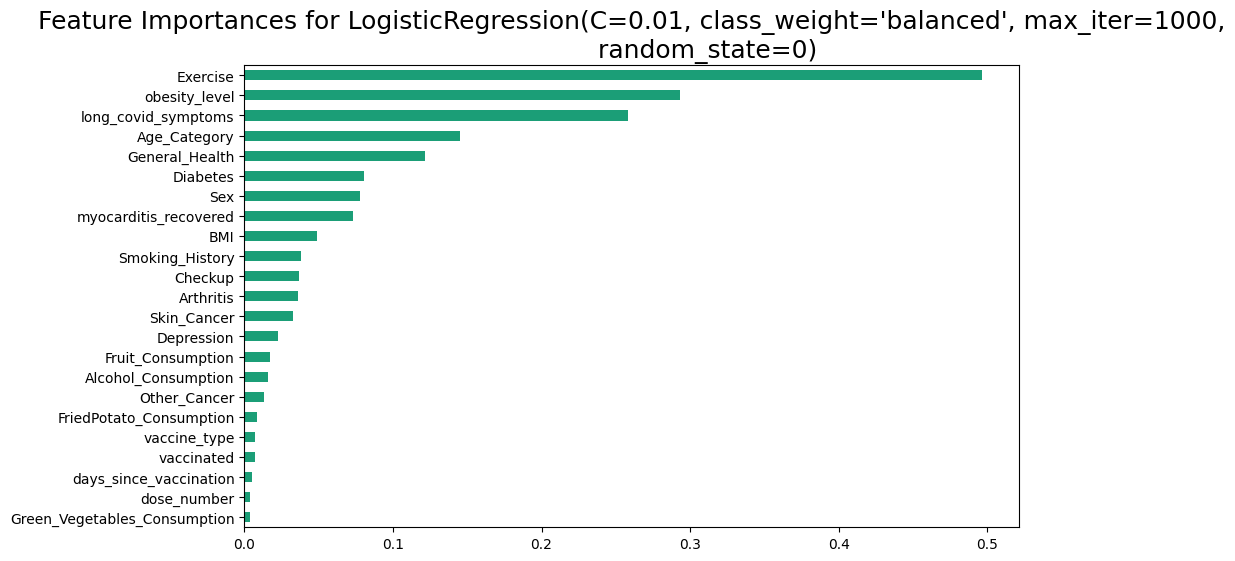

In [7]:
# Define hyperparameter grid carefully considering solver-penalty compatibility
param_grid = [
    {'C': [100,10,1,0.1,0.01,0.001],
     'penalty': ['l1'],
     'solver': ['liblinear', 'saga']},
    {'C': [100,10,1,0.1,0.01,0.001],
     'penalty': ['l2'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
]

# Initialize Logistic Regression without specifying solver or penalty upfront
logreg = LogisticRegression(fit_intercept=True, max_iter=1000, random_state=0, class_weight='balanced')

# Repeated Stratified K-Fold CV
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=4, random_state=0)

# Setup GridSearchCV with logistic regression and your param_grid
grid = GridSearchCV(logreg, param_grid, cv=rskf, n_jobs=-1, scoring='roc_auc')  # or your preferred scoring metric

# Fit on scaled training data
grid.fit(X_train_scaled, y_train)

# Best hyperparameters
best_params = grid.best_params_
print("Best hyperparameters:", best_params)

# Train model with best params
lr_model2 = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver=best_params['solver'],
    max_iter=1000,
    random_state=0,
    class_weight='balanced'
)

# Fit on full training data
lr_model2.fit(X_train_scaled, y_train)

# Evaluate your model (assuming you have an evaluate_model function)
lr_score2 = evaluate_model(lr_model2, X_train_scaled, X_test_scaled, y_train, y_test)

score['Logistic regression tuned'] = lr_score2


Train ROC AUC: 0.6570866892658489
Test ROC AUC: 0.6530858954396722


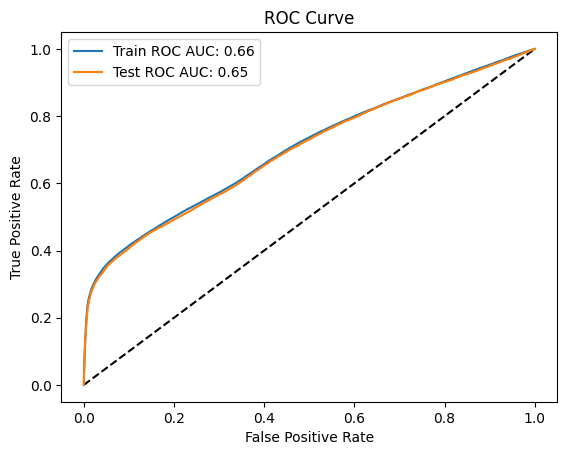


Confusion Matrix:


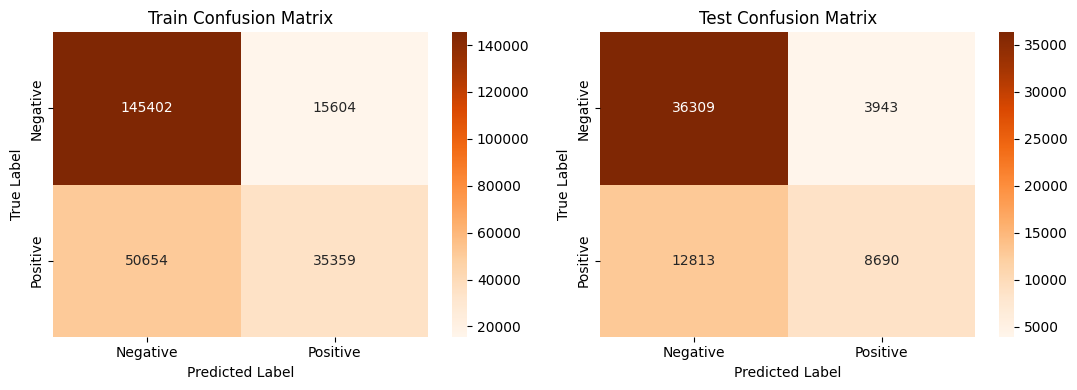


Train Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.741635 | 0.903084 |   0.814436 | 161006       |
| 1            |    0.693817 | 0.411089 |   0.51628  |  86013       |
| accuracy     |    0.73177  | 0.73177  |   0.73177  |      0.73177 |
| macro avg    |    0.717726 | 0.657087 |   0.665358 | 247019       |
| weighted avg |    0.724985 | 0.73177  |   0.710617 | 247019       |

Test Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.73916  | 0.902042 |   0.812518 | 40252       |
| 1            |    0.687881 | 0.40413  |   0.50914  | 21503       |
| accuracy     |    0.72867  | 0.72867  |   0.72867  |     0.72867 |
| macro avg    |    0.71352  | 0.653086 |   0.660829 | 61755       |
| weighted avg |    0.721304 | 0.7286

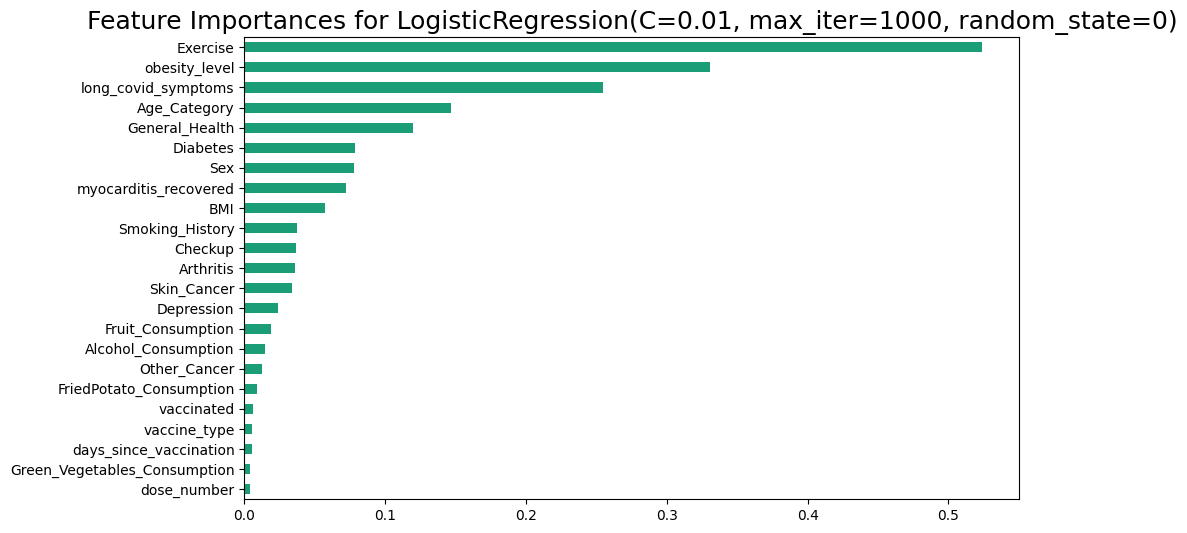

In [8]:
# Initiate model with best parameters
lr_model2 = LogisticRegression(C=best_params['C'],
                                  penalty=best_params['penalty'],
                                  solver=best_params['solver'],
                                  max_iter=1000, random_state=0)

# Visualizing evaluation Metric Score chart
lr_score2 = evaluate_model(lr_model2, X_train_scaled, X_test_scaled, y_train, y_test)

score['Logistic regression tuned'] = lr_score2

In [9]:
# Updated Evaluation metric Score Chart
score

,Logistic regression,Logistic regression tuned
Precision Train,0.724873,0.724985
Precision Test,0.721117,0.721304
Recall Train,0.731705,0.731770
Recall Test,0.728540,0.728670
Accuracy Train,0.731705,0.731770
Accuracy Test,0.728540,0.728670
ROC-AUC Train,0.657094,0.657087
ROC-AUC Test,0.653008,0.653086
F1 macro Train,0.710598,0.710617
F1 macro Test,0.706786,0.706882


# K Nearest Neighbour 


Train ROC AUC: 0.7353861166229678
Test ROC AUC: 0.6426233188800156


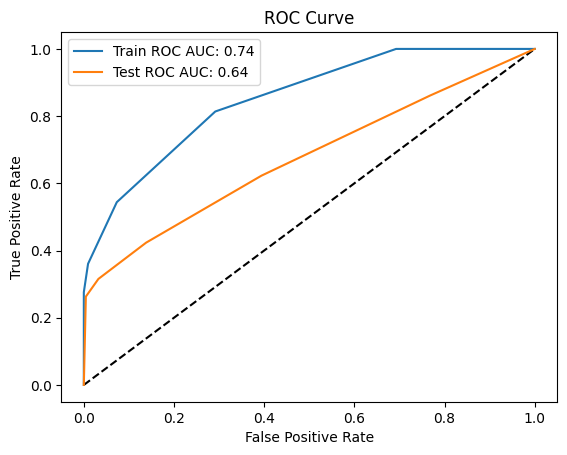


Confusion Matrix:


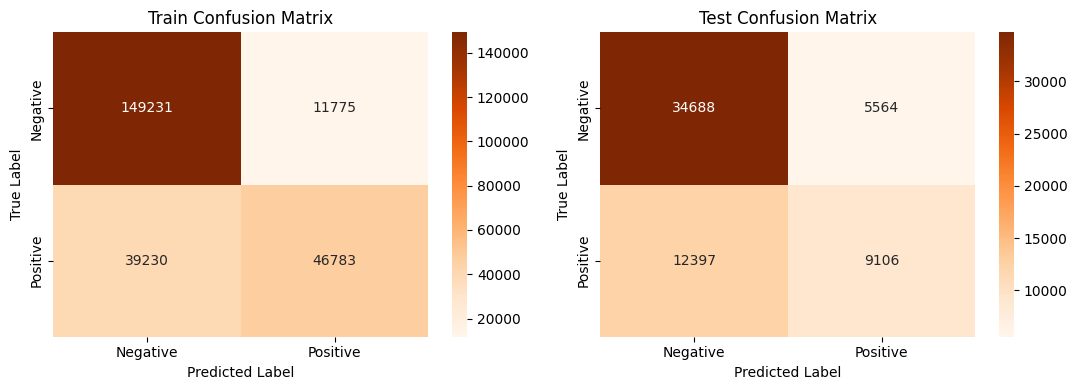


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.79184  | 0.926866 |   0.854049 | 161006        |
| 1            |    0.798917 | 0.543906 |   0.647198 |  86013        |
| accuracy     |    0.793518 | 0.793518 |   0.793518 |      0.793518 |
| macro avg    |    0.795379 | 0.735386 |   0.750623 | 247019        |
| weighted avg |    0.794304 | 0.793518 |   0.782023 | 247019        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.73671  | 0.861771 |   0.794348 | 40252        |
| 1            |    0.620723 | 0.423476 |   0.503469 | 21503        |
| accuracy     |    0.709157 | 0.709157 |   0.709157 |     0.709157 |
| macro avg    |    0.678716 | 0.642623 |   0.648909 | 61755        |
| weighted avg |    0.69

,Logistic regression,Logistic regression tuned,K-Nearest Neighbour
Precision Train,0.724873,0.724985,0.794304
Precision Test,0.721117,0.721304,0.696323
Recall Train,0.731705,0.731770,0.793518
Recall Test,0.728540,0.728670,0.709157
Accuracy Train,0.731705,0.731770,0.793518
Accuracy Test,0.728540,0.728670,0.709157
ROC-AUC Train,0.657094,0.657087,0.735386
ROC-AUC Test,0.653008,0.653086,0.642623
F1 macro Train,0.710598,0.710617,0.782023
F1 macro Test,0.706786,0.706882,0.693065


In [10]:
knn_model =  KNeighborsClassifier(n_neighbors=5)

knn_score = evaluate_model(knn_model, X_train_scaled, X_test_scaled, y_train, y_test)

score['K-Nearest Neighbour'] = knn_score
score

# SVM


Train ROC AUC: 0.6637279548362329
Test ROC AUC: 0.6526876975033867


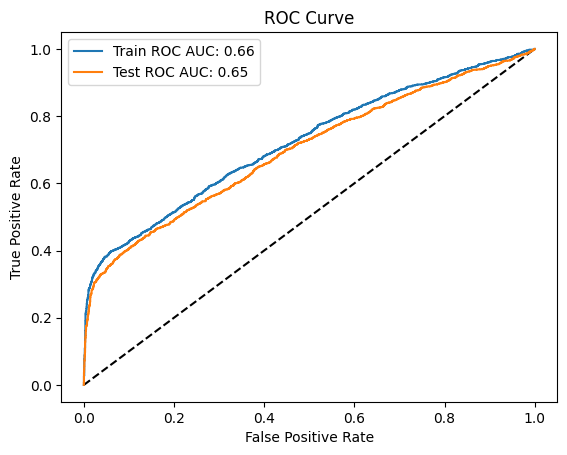


Confusion Matrix:


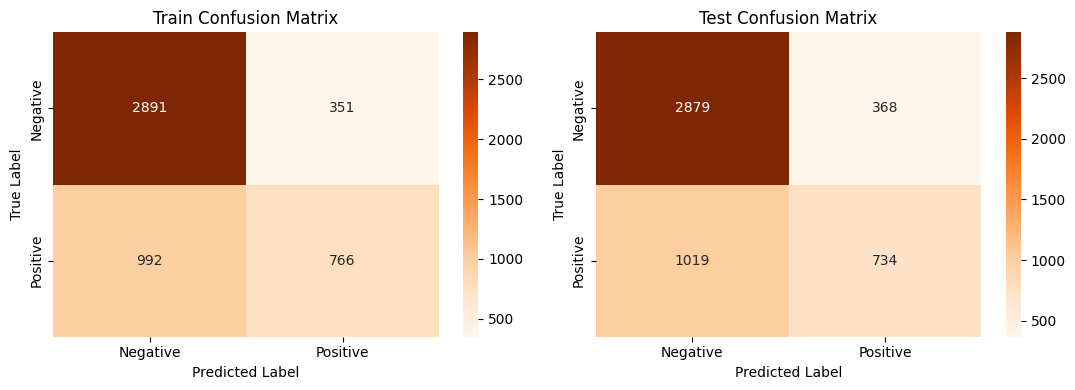


Train Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    0.744527 | 0.891733 |   0.811509 | 3242      |
| 1            |    0.685765 | 0.435722 |   0.53287  | 1758      |
| accuracy     |    0.7314   | 0.7314   |   0.7314   |    0.7314 |
| macro avg    |    0.715146 | 0.663728 |   0.672189 | 5000      |
| weighted avg |    0.723867 | 0.7314   |   0.713539 | 5000      |

Test Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    0.738584 | 0.886665 |   0.805878 | 3247      |
| 1            |    0.666062 | 0.418711 |   0.514186 | 1753      |
| accuracy     |    0.7226   | 0.7226   |   0.7226   |    0.7226 |
| macro avg    |    0.702323 | 0.652688 |   0.660032 | 5000      |
| weighted avg |    0.713158 | 0.7226   |   0.703611 | 5000      |

Th

In [11]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svm_raw = LinearSVC(random_state=0, max_iter=5000)
svm_model = CalibratedClassifierCV(svm_raw)  # Adds predict_proba

# Fit on small subset if full data is too big
X_small = X_train_scaled[:5000]
y_small = y_train[:5000]
svm_model.fit(X_small, y_small)

# Evaluate
svm_score = evaluate_model(svm_model, X_small, X_test_scaled[:5000], y_small, y_test[:5000])
score['LinearSVM_calibrated'] = svm_score

print("SVM done!")

# Store the score in the dictionary
score['SVM'] = svm_score

# View score dictionary
print(score)

In [12]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from skopt import BayesSearchCV
from skopt.space import Real

# Define parameter space
param_space = {'estimator__C': Real(0.01, 10.0, prior='log-uniform')}

# LinearSVC with calibration
base_svm = LinearSVC(random_state=0, max_iter=5000)
svm = CalibratedClassifierCV(estimator=base_svm, method='sigmoid', cv=3)

# Bayesian optimization
random_search = BayesSearchCV(
    estimator=svm,
    search_spaces=param_space,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    random_state=0
)

# Use smaller data sample to keep training fast
X_small = X_train_scaled[:3000]
y_small = y_test[:3000]

random_search.fit(X_small, y_small)
best_params = random_search.best_params_

print("✅ Best hyperparameters:", random_search.best_params_)

✅ Best hyperparameters: OrderedDict([('estimator__C', 0.3916449174261764)])



Train ROC AUC: 0.6549303225266476
Test ROC AUC: 0.6511372097357591


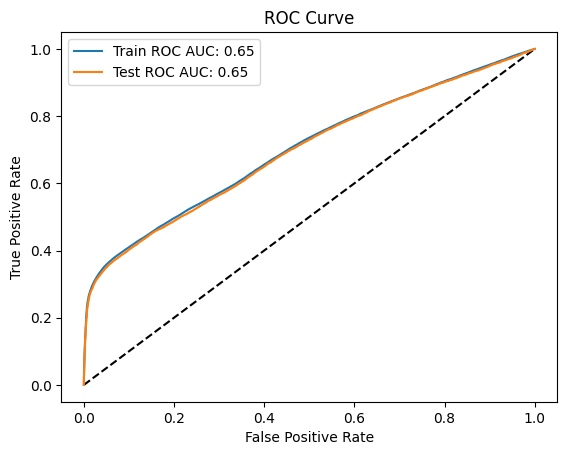


Confusion Matrix:


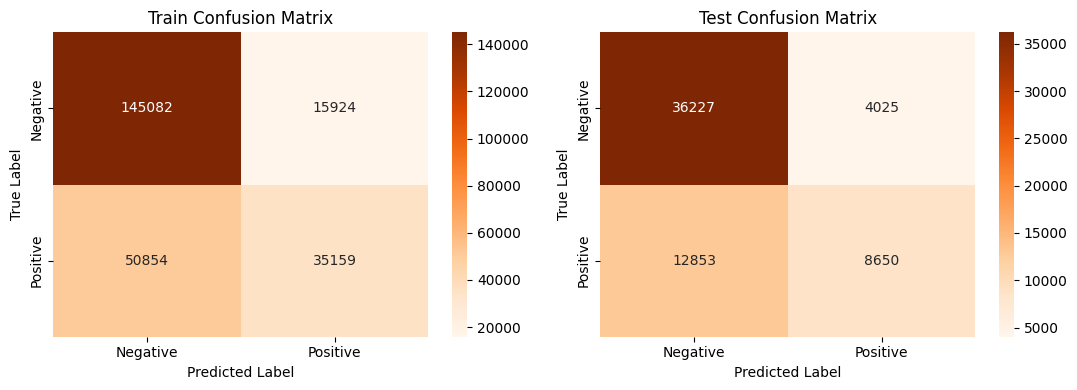


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.740456 | 0.901097 |   0.812916 | 161006        |
| 1            |    0.688272 | 0.408764 |   0.512911 |  86013        |
| accuracy     |    0.729665 | 0.729665 |   0.729665 |      0.729665 |
| macro avg    |    0.714364 | 0.65493  |   0.662914 | 247019        |
| weighted avg |    0.722285 | 0.729665 |   0.708453 | 247019        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.738121 | 0.900005 |   0.811064 | 40252        |
| 1            |    0.682446 | 0.402269 |   0.506174 | 21503        |
| accuracy     |    0.726694 | 0.726694 |   0.726694 |     0.726694 |
| macro avg    |    0.710284 | 0.651137 |   0.658619 | 61755        |
| weighted avg |    0.71

In [13]:
base_svm = LinearSVC(C=best_params['estimator__C'], random_state=0, max_iter=5000)
svm_model2 = CalibratedClassifierCV(base_svm, method='sigmoid', cv=3)

# Fit on your full training data
svm_model2.fit(X_train_scaled, y_train)

# Evaluate
svm2_score = evaluate_model(svm_model2, X_train_scaled, X_test_scaled, y_train, y_test)


Train ROC AUC: 0.6549303225266476
Test ROC AUC: 0.6511372097357591


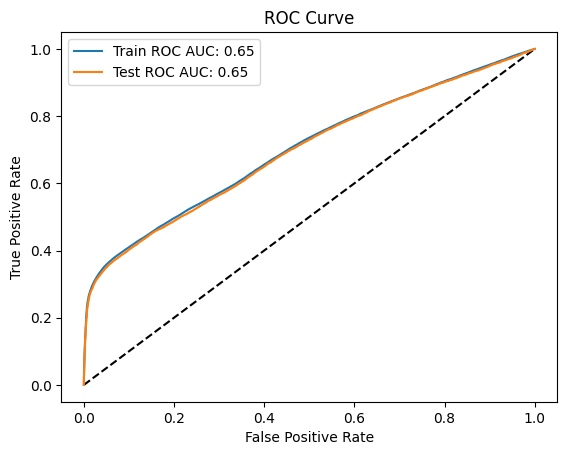


Confusion Matrix:


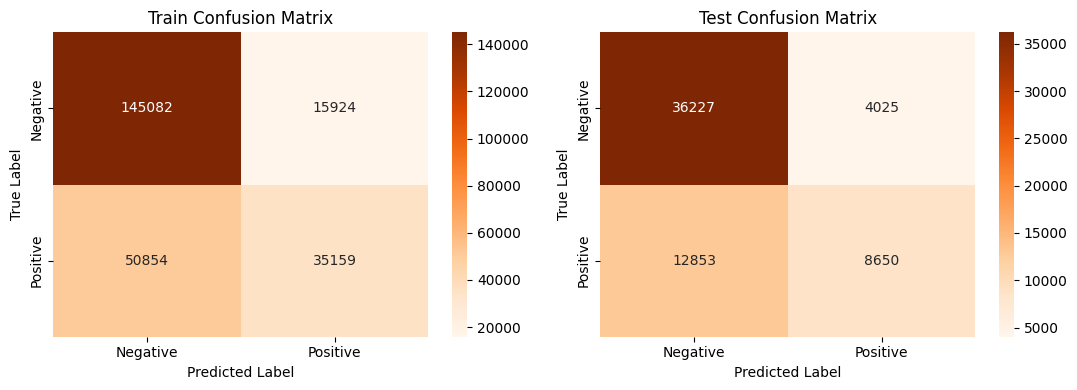


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.740456 | 0.901097 |   0.812916 | 161006        |
| 1            |    0.688272 | 0.408764 |   0.512911 |  86013        |
| accuracy     |    0.729665 | 0.729665 |   0.729665 |      0.729665 |
| macro avg    |    0.714364 | 0.65493  |   0.662914 | 247019        |
| weighted avg |    0.722285 | 0.729665 |   0.708453 | 247019        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.738121 | 0.900005 |   0.811064 | 40252        |
| 1            |    0.682446 | 0.402269 |   0.506174 | 21503        |
| accuracy     |    0.726694 | 0.726694 |   0.726694 |     0.726694 |
| macro avg    |    0.710284 | 0.651137 |   0.658619 | 61755        |
| weighted avg |    0.71

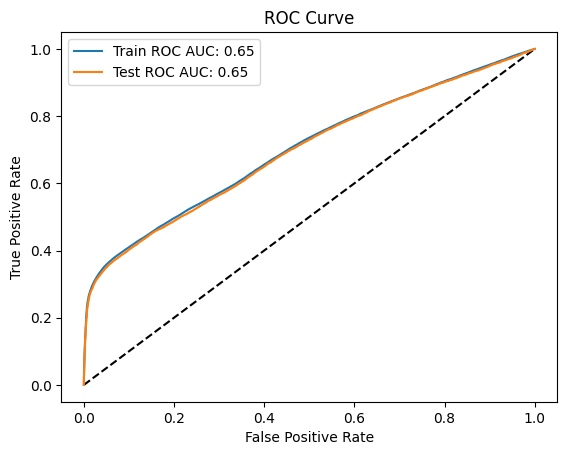


Confusion Matrix:


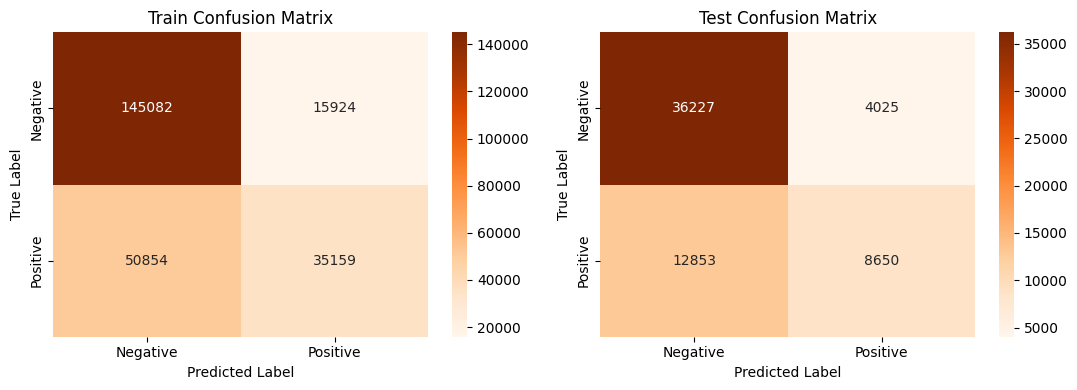


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.740456 | 0.901097 |   0.812916 | 161006        |
| 1            |    0.688272 | 0.408764 |   0.512911 |  86013        |
| accuracy     |    0.729665 | 0.729665 |   0.729665 |      0.729665 |
| macro avg    |    0.714364 | 0.65493  |   0.662914 | 247019        |
| weighted avg |    0.722285 | 0.729665 |   0.708453 | 247019        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.738121 | 0.900005 |   0.811064 | 40252        |
| 1            |    0.682446 | 0.402269 |   0.506174 | 21503        |
| accuracy     |    0.726694 | 0.726694 |   0.726694 |     0.726694 |
| macro avg    |    0.710284 | 0.651137 |   0.658619 | 61755        |
| weighted avg |    0.71

In [14]:

svm_model2 = SVC(
    C=best_params['estimator__C'],  # Use the correct key from BayesSearchCV
    kernel='linear',                # Because LinearSVC only supports 'linear'
    random_state=0,
    probability=True
)
# Use the optimized, trained model directly from BayesSearchCV
svm_model2 = random_search.best_estimator_

# Evaluate using the existing function
svm2_score = evaluate_model(svm_model2, X_train_scaled, X_test_scaled, y_train, y_test)


In [15]:
score['SVM tuned'] = svm2_score
# Updated Evaluation metric Score Chart
score

,Logistic regression,Logistic regression tuned,K-Nearest Neighbour,LinearSVM_calibrated,SVM,SVM tuned
Precision Train,0.724873,0.724985,0.794304,0.723867,0.723867,0.722285
Precision Test,0.721117,0.721304,0.696323,0.713158,0.713158,0.718735
Recall Train,0.731705,0.731770,0.793518,0.731400,0.731400,0.729665
Recall Test,0.728540,0.728670,0.709157,0.722600,0.722600,0.726694
Accuracy Train,0.731705,0.731770,0.793518,0.731400,0.731400,0.729665
Accuracy Test,0.728540,0.728670,0.709157,0.722600,0.722600,0.726694
ROC-AUC Train,0.657094,0.657087,0.735386,0.663728,0.663728,0.654930
ROC-AUC Test,0.653008,0.653086,0.642623,0.652688,0.652688,0.651137
F1 macro Train,0.710598,0.710617,0.782023,0.713539,0.713539,0.708453
F1 macro Test,0.706786,0.706882,0.693065,0.703611,0.703611,0.704902


<!--  -->

# Decision Tree


Train ROC AUC: 1.0
Test ROC AUC: 0.6161354194750812


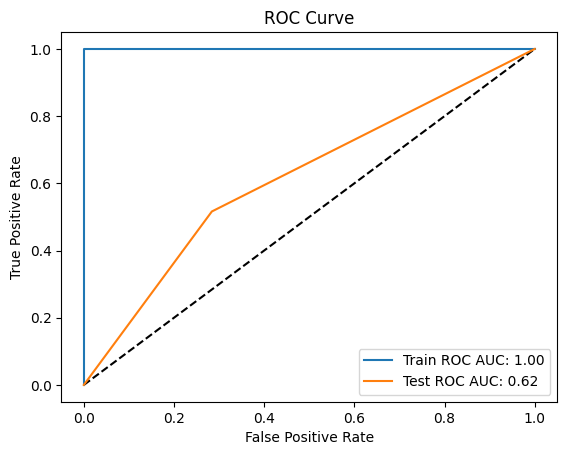


Confusion Matrix:


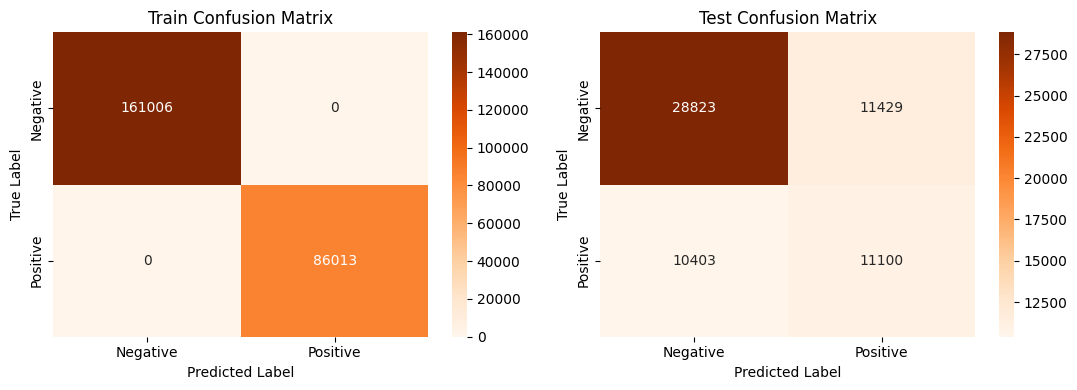


Train Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |           1 |        1 |          1 |    161006 |
| 1            |           1 |        1 |          1 |     86013 |
| accuracy     |           1 |        1 |          1 |         1 |
| macro avg    |           1 |        1 |          1 |    247019 |
| weighted avg |           1 |        1 |          1 |    247019 |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.734793 | 0.716064 |   0.725308 | 40252        |
| 1            |    0.492698 | 0.516207 |   0.504179 | 21503        |
| accuracy     |    0.646474 | 0.646474 |   0.646474 |     0.646474 |
| macro avg    |    0.613746 | 0.616135 |   0.614743 | 61755        |
| weighted avg |    0.650496 | 0.646474 |   0.648311

,Logistic regression,Logistic regression tuned,K-Nearest Neighbour,LinearSVM_calibrated,SVM,SVM tuned,Decision Tree
Precision Train,0.724873,0.724985,0.794304,0.723867,0.723867,0.722285,1.000000
Precision Test,0.721117,0.721304,0.696323,0.713158,0.713158,0.718735,0.650496
Recall Train,0.731705,0.731770,0.793518,0.731400,0.731400,0.729665,1.000000
Recall Test,0.728540,0.728670,0.709157,0.722600,0.722600,0.726694,0.646474
Accuracy Train,0.731705,0.731770,0.793518,0.731400,0.731400,0.729665,1.000000
Accuracy Test,0.728540,0.728670,0.709157,0.722600,0.722600,0.726694,0.646474
ROC-AUC Train,0.657094,0.657087,0.735386,0.663728,0.663728,0.654930,1.000000
ROC-AUC Test,0.653008,0.653086,0.642623,0.652688,0.652688,0.651137,0.616135
F1 macro Train,0.710598,0.710617,0.782023,0.713539,0.713539,0.708453,1.000000
F1 macro Test,0.706786,0.706882,0.693065,0.703611,0.703611,0.704902,0.648311


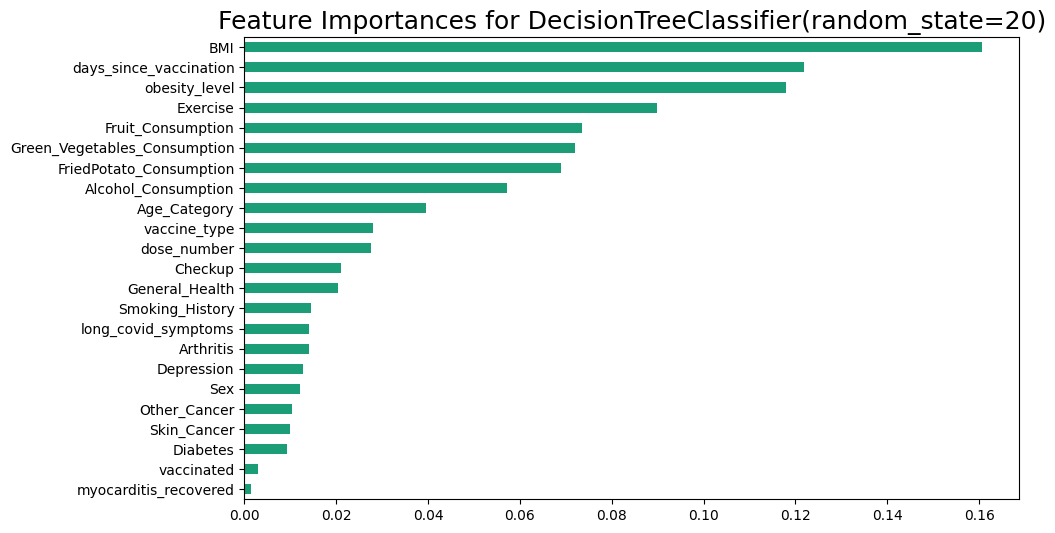

In [16]:
dt_model = DecisionTreeClassifier(random_state=20)

# Visualizing evaluation Metric Score chart
dt_score = evaluate_model(dt_model, X_train_scaled, X_test_scaled, y_train, y_test)

# Updated Evaluation metric Score Chart
score['Decision Tree'] = dt_score
score

Fitting 9 folds for each of 20 candidates, totalling 180 fits
Best hyperparameters (RandomSearchCV): {'min_samples_split': np.int64(6), 'min_samples_leaf': np.int64(19), 'max_depth': 7}

Train ROC AUC: 0.6590631881940686
Test ROC AUC: 0.5


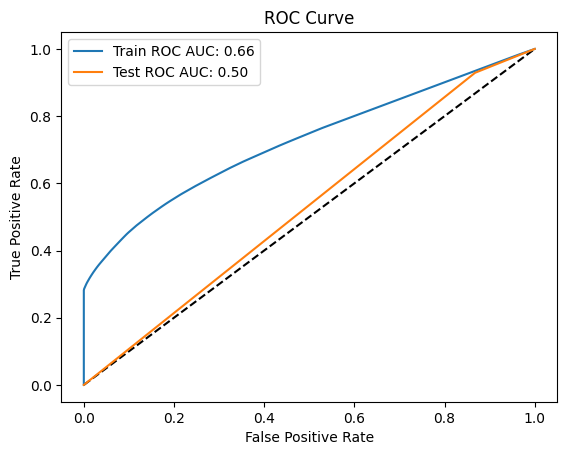


Confusion Matrix:


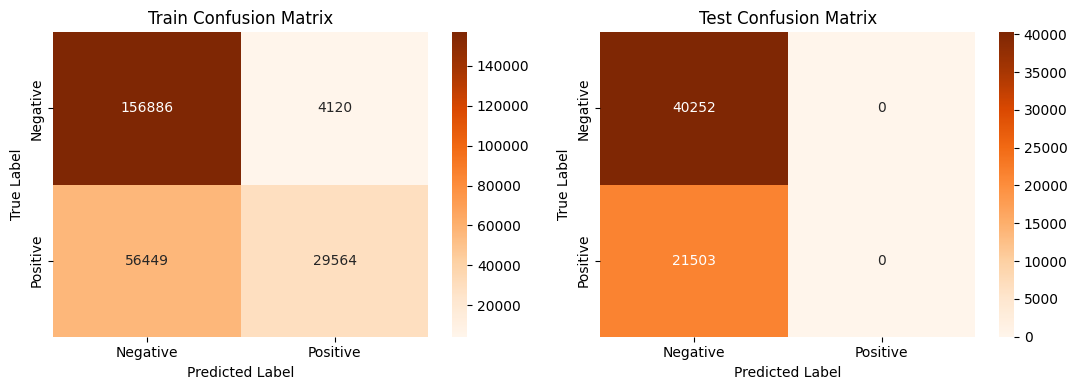


Train Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.735397 | 0.974411 |   0.838198 | 161006      |
| 1            |    0.877687 | 0.343715 |   0.493981 |  86013      |
| accuracy     |    0.7548   | 0.7548   |   0.7548   |      0.7548 |
| macro avg    |    0.806542 | 0.659063 |   0.666089 | 247019      |
| weighted avg |    0.784943 | 0.7548   |   0.71834  | 247019      |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.651801 | 1        |   0.789201 | 40252        |
| 1            |    0        | 0        |   0        | 21503        |
| accuracy     |    0.651801 | 0.651801 |   0.651801 |     0.651801 |
| macro avg    |    0.325901 | 0.5      |   0.3946   | 61755        |
| weighted avg |    0.424845 | 0.65180

,Logistic regression,Logistic regression tuned,K-Nearest Neighbour,LinearSVM_calibrated,SVM,SVM tuned,Decision Tree,Decision Tree Tuned
Precision Train,0.724873,0.724985,0.794304,0.723867,0.723867,0.722285,1.000000,0.784943
Precision Test,0.721117,0.721304,0.696323,0.713158,0.713158,0.718735,0.650496,0.424845
Recall Train,0.731705,0.731770,0.793518,0.731400,0.731400,0.729665,1.000000,0.754800
Recall Test,0.728540,0.728670,0.709157,0.722600,0.722600,0.726694,0.646474,0.651801
Accuracy Train,0.731705,0.731770,0.793518,0.731400,0.731400,0.729665,1.000000,0.754800
Accuracy Test,0.728540,0.728670,0.709157,0.722600,0.722600,0.726694,0.646474,0.651801
ROC-AUC Train,0.657094,0.657087,0.735386,0.663728,0.663728,0.654930,1.000000,0.659063
ROC-AUC Test,0.653008,0.653086,0.642623,0.652688,0.652688,0.651137,0.616135,0.500000
F1 macro Train,0.710598,0.710617,0.782023,0.713539,0.713539,0.708453,1.000000,0.718340
F1 macro Test,0.706786,0.706882,0.693065,0.703611,0.703611,0.704902,0.648311,0.514402


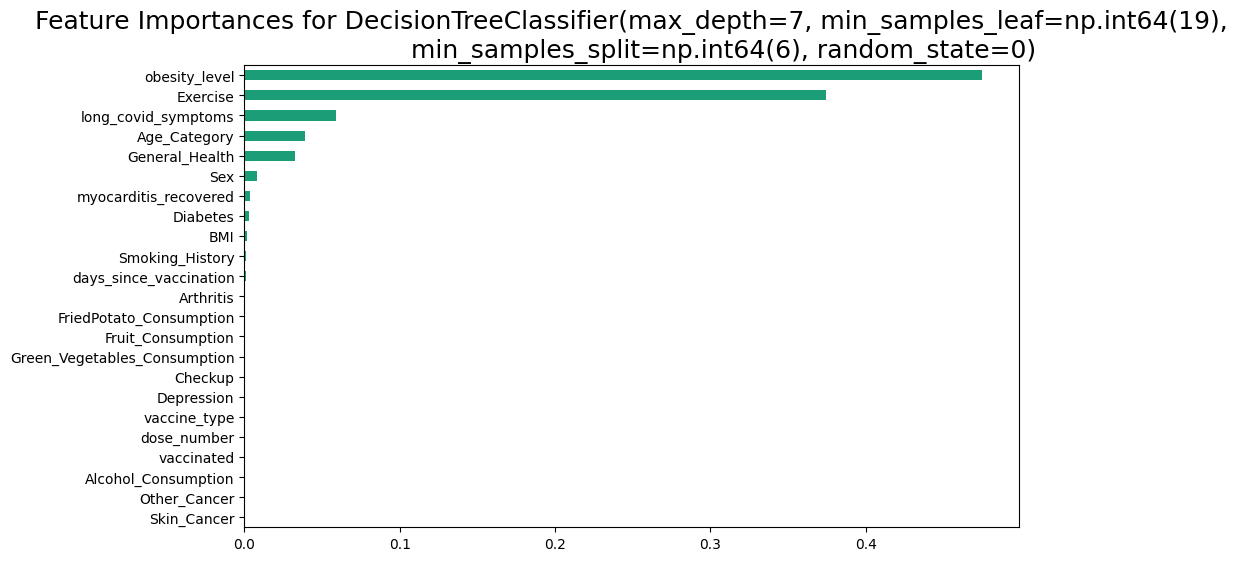

In [17]:
# Define the hyperparameter distribution
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': np.arange(2, 8),
    'min_samples_leaf': np.arange(10, 20)
}

# Initialize the model
model = DecisionTreeClassifier(random_state=0)

# Repeated Stratified K-Fold
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=0)

# Randomized Search with fewer iterations
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,                 # Try 20 random combinations
    cv=rskf,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=0,
    verbose=1
)

# Fit the search
random_search.fit(X_train_scaled, y_train)

# Best parameters
best_params_tree = random_search.best_params_
print("Best hyperparameters (RandomSearchCV):", best_params_tree)

# Train final model
tree_model = DecisionTreeClassifier(**best_params_tree, random_state=0)
tree_model.fit(X_train_scaled, y_train)

# Evaluate
tree_score = evaluate_model(tree_model, X_train_scaled, X_test, y_train, y_test)

# Store score
score['Decision Tree Tuned'] = tree_score

# ✅ Fixed print statement
print("Best hyperparameters: ", best_params_tree)
score

# Random Forest


Train ROC AUC: 0.9999941869252322
Test ROC AUC: 0.5027186910853938


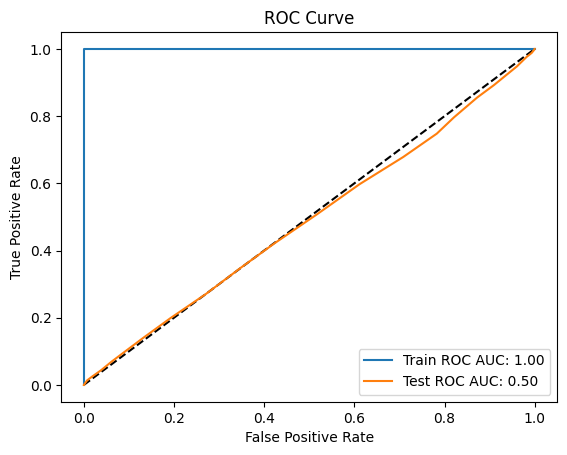


Confusion Matrix:


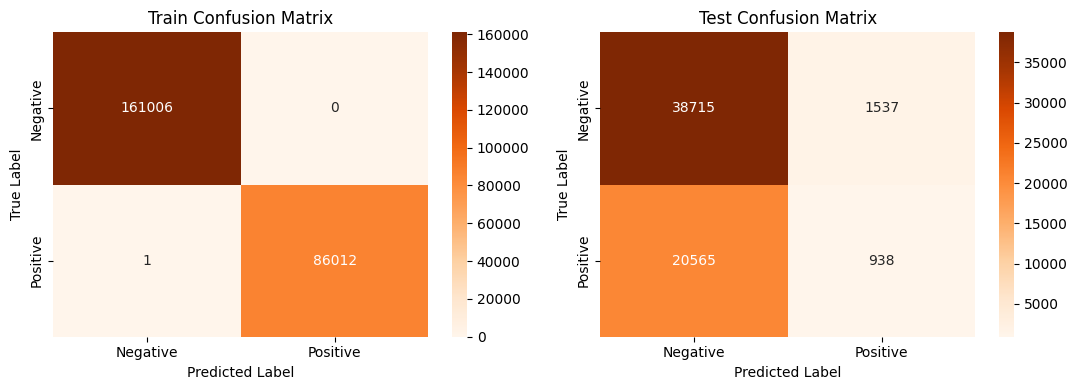


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.999994 | 1        |   0.999997 | 161006        |
| 1            |    1        | 0.999988 |   0.999994 |  86013        |
| accuracy     |    0.999996 | 0.999996 |   0.999996 |      0.999996 |
| macro avg    |    0.999997 | 0.999994 |   0.999996 | 247019        |
| weighted avg |    0.999996 | 0.999996 |   0.999996 | 247019        |

Test Classification Report:
|              |   precision |    recall |   f1-score |      support |
|:-------------|------------:|----------:|-----------:|-------------:|
| 0            |    0.653087 | 0.961816  |  0.777941  | 40252        |
| 1            |    0.37899  | 0.0436218 |  0.0782384 | 21503        |
| accuracy     |    0.642102 | 0.642102  |  0.642102  |     0.642102 |
| macro avg    |    0.516038 | 0.502719  |  0.42809   | 61755        |
| weighted avg |  

,Logistic regression,Logistic regression tuned,K-Nearest Neighbour,LinearSVM_calibrated,SVM,SVM tuned,Decision Tree,Decision Tree Tuned,Random Forest
Precision Train,0.724873,0.724985,0.794304,0.723867,0.723867,0.722285,1.000000,0.784943,0.999996
Precision Test,0.721117,0.721304,0.696323,0.713158,0.713158,0.718735,0.650496,0.424845,0.557647
Recall Train,0.731705,0.731770,0.793518,0.731400,0.731400,0.729665,1.000000,0.754800,0.999996
Recall Test,0.728540,0.728670,0.709157,0.722600,0.722600,0.726694,0.646474,0.651801,0.642102
Accuracy Train,0.731705,0.731770,0.793518,0.731400,0.731400,0.729665,1.000000,0.754800,0.999996
Accuracy Test,0.728540,0.728670,0.709157,0.722600,0.722600,0.726694,0.646474,0.651801,0.642102
ROC-AUC Train,0.657094,0.657087,0.735386,0.663728,0.663728,0.654930,1.000000,0.659063,0.999994
ROC-AUC Test,0.653008,0.653086,0.642623,0.652688,0.652688,0.651137,0.616135,0.500000,0.502719
F1 macro Train,0.710598,0.710617,0.782023,0.713539,0.713539,0.708453,1.000000,0.718340,0.999996
F1 macro Test,0.706786,0.706882,0.693065,0.703611,0.703611,0.704902,0.648311,0.514402,0.534305


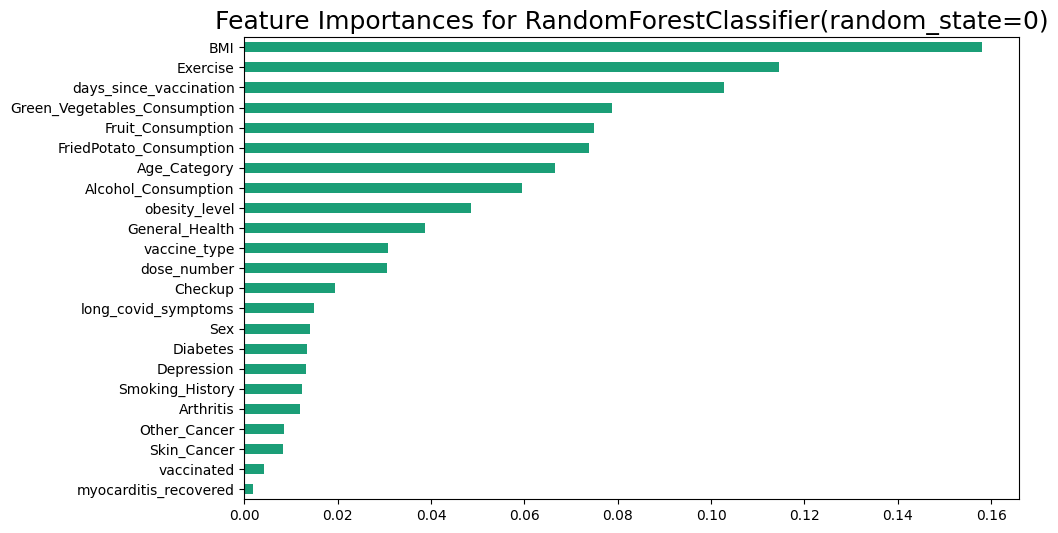

In [18]:
rf_model = RandomForestClassifier(random_state=0)
# Visualizing evaluation Metric Score chart
rf_score = evaluate_model(rf_model, X_train_scaled, X_test, y_train, y_test)

# Updated Evaluation metric Score Chart
score['Random Forest'] = rf_score
score

# XGBoost


Train ROC AUC: 0.6773364467267259
Test ROC AUC: 0.6191382070244351


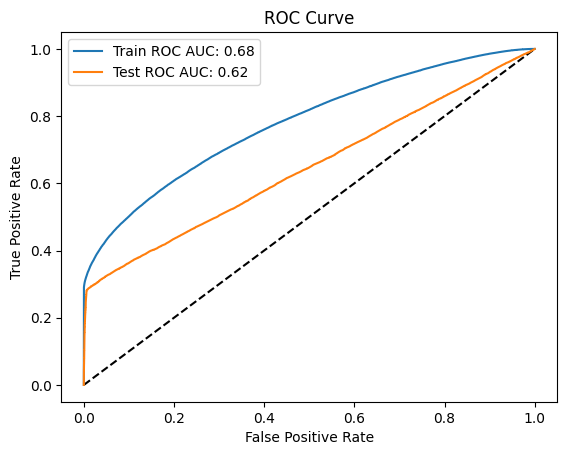


Confusion Matrix:


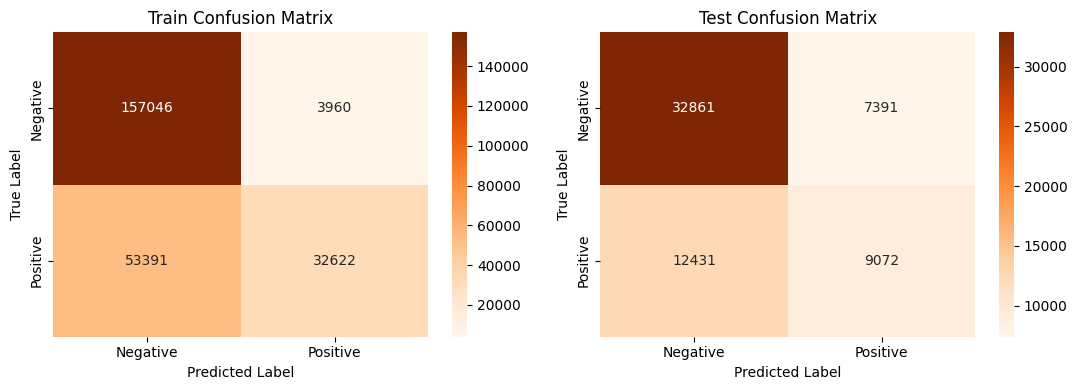


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.746285 | 0.975405 |   0.845599 | 161006        |
| 1            |    0.89175  | 0.379268 |   0.532191 |  86013        |
| accuracy     |    0.767828 | 0.767828 |   0.767828 |      0.767828 |
| macro avg    |    0.819018 | 0.677336 |   0.688895 | 247019        |
| weighted avg |    0.796937 | 0.767828 |   0.73647  | 247019        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.725537 | 0.816382 |   0.768283 | 40252        |
| 1            |    0.551054 | 0.421895 |   0.477901 | 21503        |
| accuracy     |    0.679022 | 0.679022 |   0.679022 |     0.679022 |
| macro avg    |    0.638295 | 0.619138 |   0.623092 | 61755        |
| weighted avg |    0.66

,Logistic regression,Logistic regression tuned,K-Nearest Neighbour,LinearSVM_calibrated,SVM,SVM tuned,Decision Tree,Decision Tree Tuned,Random Forest,XGB
Precision Train,0.724873,0.724985,0.794304,0.723867,0.723867,0.722285,1.000000,0.784943,0.999996,0.796937
Precision Test,0.721117,0.721304,0.696323,0.713158,0.713158,0.718735,0.650496,0.424845,0.557647,0.664782
Recall Train,0.731705,0.731770,0.793518,0.731400,0.731400,0.729665,1.000000,0.754800,0.999996,0.767828
Recall Test,0.728540,0.728670,0.709157,0.722600,0.722600,0.726694,0.646474,0.651801,0.642102,0.679022
Accuracy Train,0.731705,0.731770,0.793518,0.731400,0.731400,0.729665,1.000000,0.754800,0.999996,0.767828
Accuracy Test,0.728540,0.728670,0.709157,0.722600,0.722600,0.726694,0.646474,0.651801,0.642102,0.679022
ROC-AUC Train,0.657094,0.657087,0.735386,0.663728,0.663728,0.654930,1.000000,0.659063,0.999994,0.677336
ROC-AUC Test,0.653008,0.653086,0.642623,0.652688,0.652688,0.651137,0.616135,0.500000,0.502719,0.619138
F1 macro Train,0.710598,0.710617,0.782023,0.713539,0.713539,0.708453,1.000000,0.718340,0.999996,0.736470
F1 macro Test,0.706786,0.706882,0.693065,0.703611,0.703611,0.704902,0.648311,0.514402,0.534305,0.667173


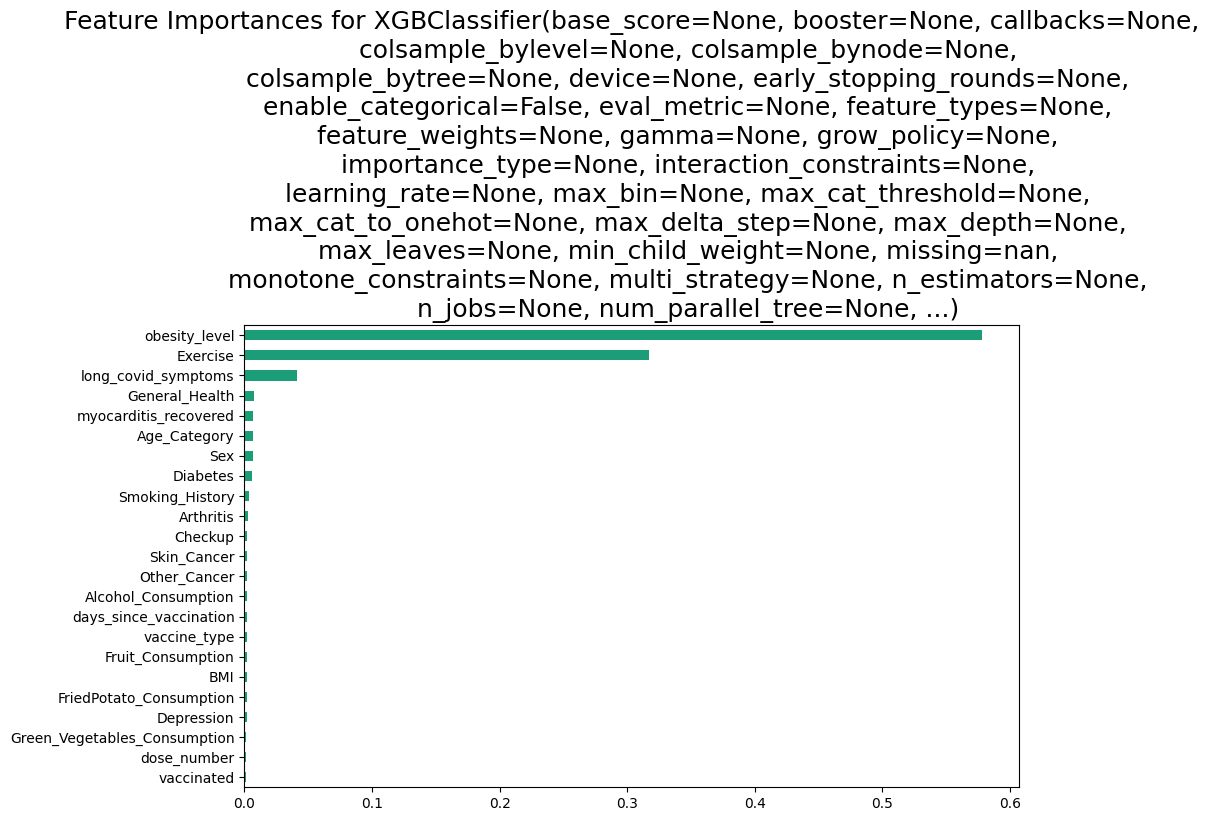

In [19]:
xgb_model = xgb.XGBClassifier()

# Visualizing evaluation Metric Score chart
xgb_score = evaluate_model(xgb_model, X_train_scaled, X_test, y_train, y_test)

# Updated Evaluation metric Score Chart
score['XGB'] = xgb_score
score

Fitting 9 folds for each of 10 candidates, totalling 90 fits
Best hyperparameters:  {'n_estimators': np.int64(170), 'max_depth': np.int64(6), 'learning_rate': np.float64(0.03)}

Train ROC AUC: 0.6617291010516024
Test ROC AUC: 0.6377659731276089


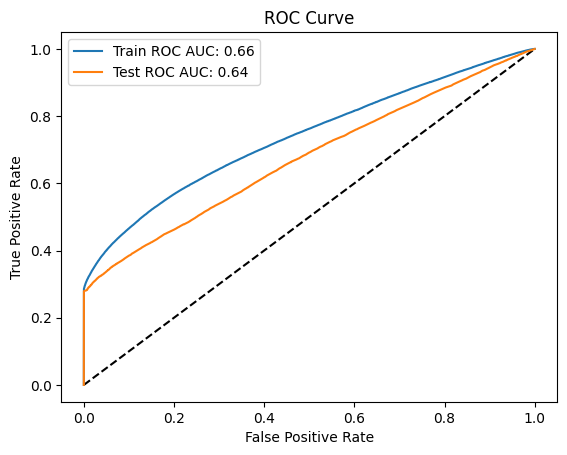


Confusion Matrix:


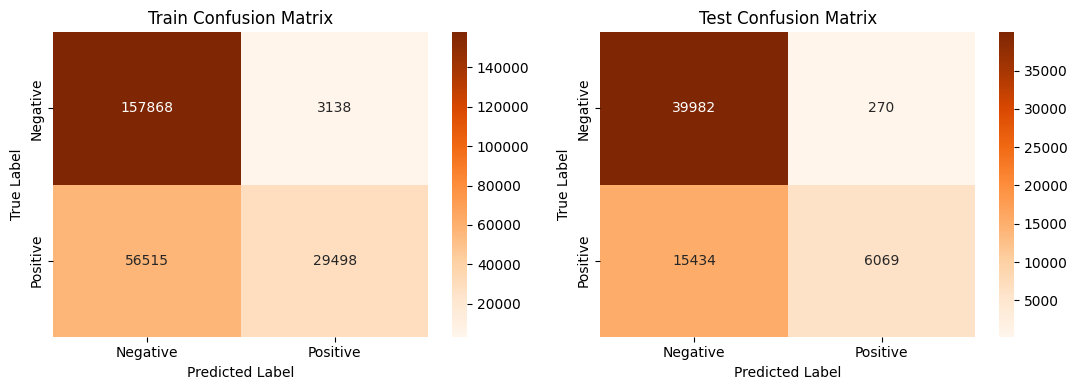


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.736383 | 0.98051  |   0.84109  | 161006        |
| 1            |    0.903849 | 0.342948 |   0.497231 |  86013        |
| accuracy     |    0.758508 | 0.758508 |   0.758508 |      0.758508 |
| macro avg    |    0.820116 | 0.661729 |   0.669161 | 247019        |
| weighted avg |    0.794695 | 0.758508 |   0.721357 | 247019        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.721488 | 0.993292 |   0.835849 | 40252        |
| 1            |    0.957407 | 0.28224  |   0.43596  | 21503        |
| accuracy     |    0.745705 | 0.745705 |   0.745705 |     0.745705 |
| macro avg    |    0.839447 | 0.637766 |   0.635905 | 61755        |
| weighted avg |    0.80

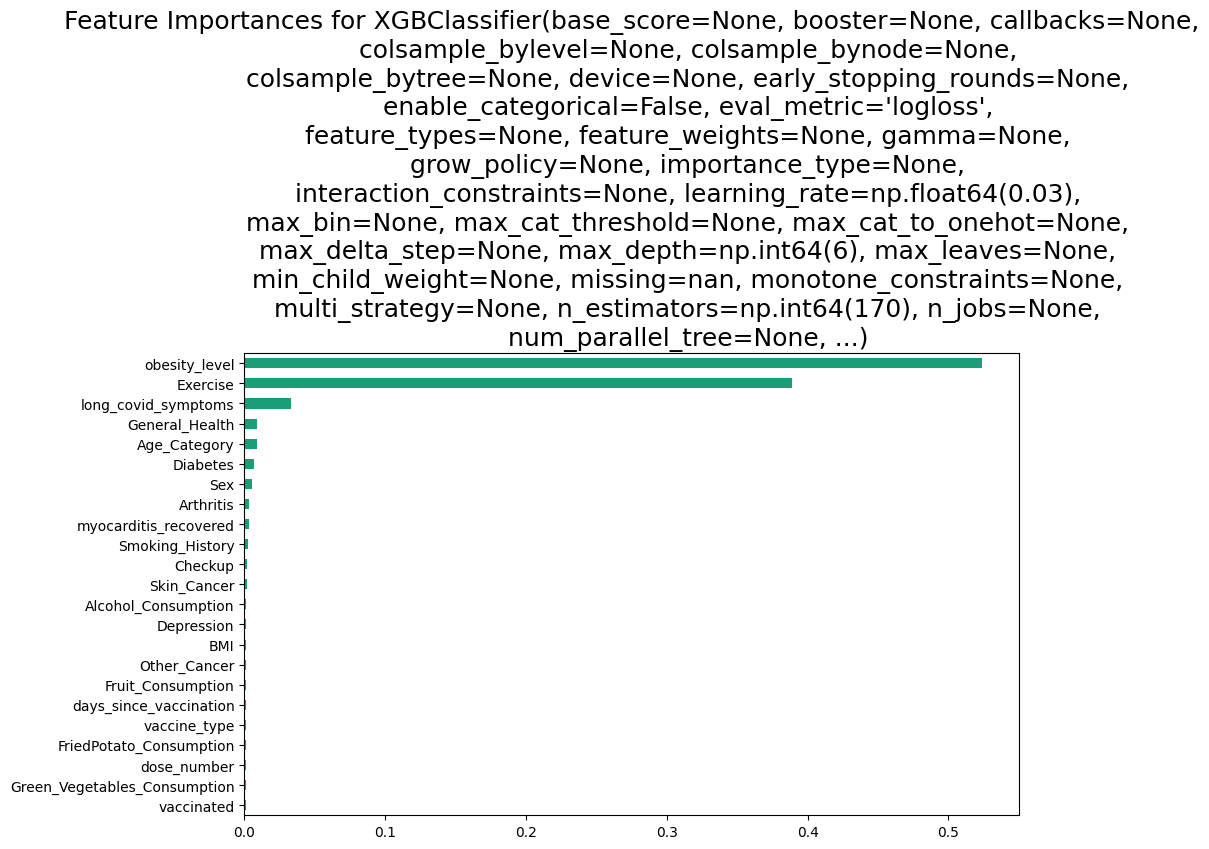

In [20]:

# Define the hyperparameter grid
param_grid = {
    'learning_rate': np.arange(0.01, 0.3, 0.01),
    'max_depth': np.arange(3, 15, 1),
    'n_estimators': np.arange(100, 200, 10)
}

# Initialize the base model
xgb2 = xgb.XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss')

# Setup cross-validation strategy
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=0)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb2,
    param_distributions=param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=rskf,
    verbose=1,
    n_jobs=-1,
    random_state=0
)

# Fit the search
random_search.fit(X_train_scaled, y_train)

# Retrieve best hyperparameters
best_params = random_search.best_params_
print("Best hyperparameters: ", best_params)

# Initialize and train final model with best parameters
xgb_model2 = xgb.XGBClassifier(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    random_state=0,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Evaluate and store score
xgb2_score = evaluate_model(xgb_model2, X_train_scaled, X_test, y_train, y_test)

# Store result
score['XGB tuned'] = xgb2_score

# Print all scores
print("\nScore dictionary:", score)

# Navies Bayes

In [21]:
xgb.XGBClassifier(scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1]))


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)


Train ROC AUC: 0.6572621832079706
Test ROC AUC: 0.5373738712169233


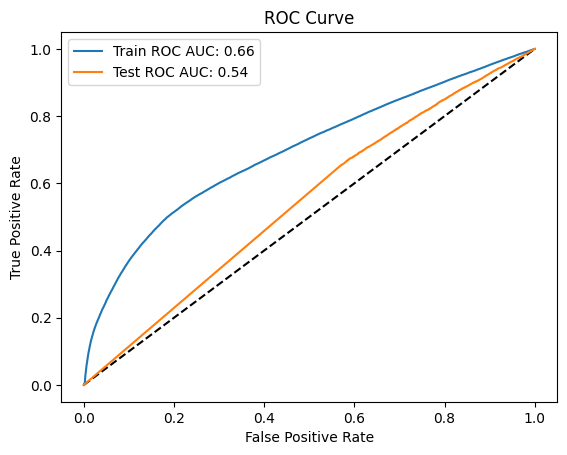


Confusion Matrix:


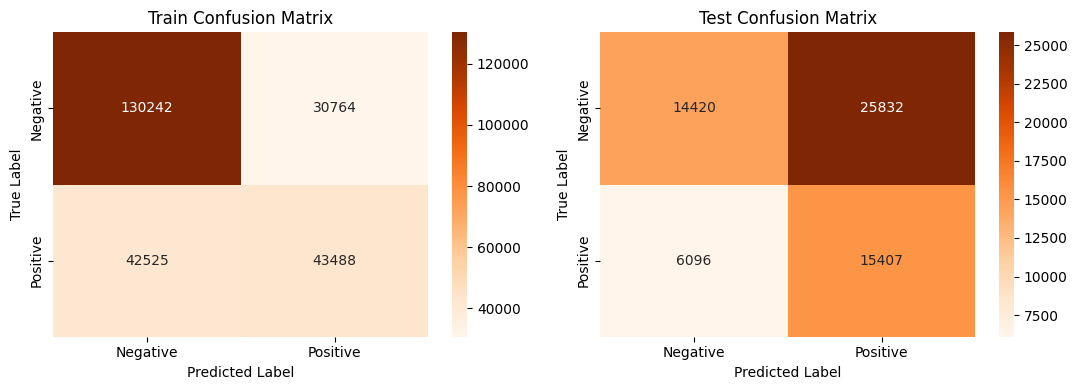


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.753859 | 0.808926 |   0.780423 | 161006        |
| 1            |    0.585681 | 0.505598 |   0.542701 |  86013        |
| accuracy     |    0.703306 | 0.703306 |   0.703306 |      0.703306 |
| macro avg    |    0.66977  | 0.657262 |   0.661562 | 247019        |
| weighted avg |    0.695299 | 0.703306 |   0.697647 | 247019        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.702866 | 0.358243 |   0.474592 | 40252        |
| 1            |    0.373603 | 0.716505 |   0.491122 | 21503        |
| accuracy     |    0.482989 | 0.482989 |   0.482989 |     0.482989 |
| macro avg    |    0.538234 | 0.537374 |   0.482857 | 61755        |
| weighted avg |    0.58

,Logistic regression,Logistic regression tuned,K-Nearest Neighbour,LinearSVM_calibrated,SVM,SVM tuned,Decision Tree,Decision Tree Tuned,Random Forest,XGB,XGB tuned,Naive Bayes
Precision Train,0.724873,0.724985,0.794304,0.723867,0.723867,0.722285,1.000000,0.784943,0.999996,0.796937,0.794695,0.695299
Precision Test,0.721117,0.721304,0.696323,0.713158,0.713158,0.718735,0.650496,0.424845,0.557647,0.664782,0.803635,0.588217
Recall Train,0.731705,0.731770,0.793518,0.731400,0.731400,0.729665,1.000000,0.754800,0.999996,0.767828,0.758508,0.703306
Recall Test,0.728540,0.728670,0.709157,0.722600,0.722600,0.726694,0.646474,0.651801,0.642102,0.679022,0.745705,0.482989
Accuracy Train,0.731705,0.731770,0.793518,0.731400,0.731400,0.729665,1.000000,0.754800,0.999996,0.767828,0.758508,0.703306
Accuracy Test,0.728540,0.728670,0.709157,0.722600,0.722600,0.726694,0.646474,0.651801,0.642102,0.679022,0.745705,0.482989
ROC-AUC Train,0.657094,0.657087,0.735386,0.663728,0.663728,0.654930,1.000000,0.659063,0.999994,0.677336,0.661729,0.657262
ROC-AUC Test,0.653008,0.653086,0.642623,0.652688,0.652688,0.651137,0.616135,0.500000,0.502719,0.619138,0.637766,0.537374
F1 macro Train,0.710598,0.710617,0.782023,0.713539,0.713539,0.708453,1.000000,0.718340,0.999996,0.736470,0.721357,0.697647
F1 macro Test,0.706786,0.706882,0.693065,0.703611,0.703611,0.704902,0.648311,0.514402,0.534305,0.667173,0.696608,0.480348


In [22]:
nb_model = GaussianNB()
# Visualizing evaluation Metric Score chart
nb_score = evaluate_model(nb_model, X_train_scaled, X_test, y_train, y_test)

# Updated Evaluation metric Score Chart
score['Naive Bayes'] = nb_score
score

In [23]:
score['Naive Bayes'] = nb_score
print("Train label distribution:\n", pd.Series(y_train).value_counts())
print("Test label distribution:\n", pd.Series(y_test).value_counts())


Train label distribution:
 CHD_Risk
0    161006
1     86013
Name: count, dtype: int64
Test label distribution:
 CHD_Risk
0    40252
1    21503
Name: count, dtype: int64


Best hyperparameters:  {'var_smoothing': np.float64(0.657933224657568)}

Train ROC AUC: 0.6318463611555488
Test ROC AUC: 0.5381902817994669


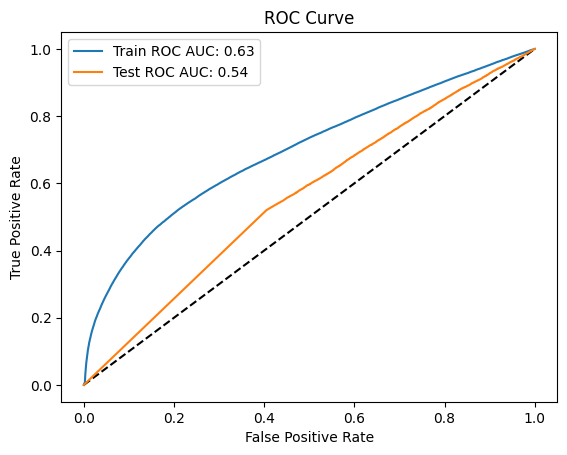


Confusion Matrix:


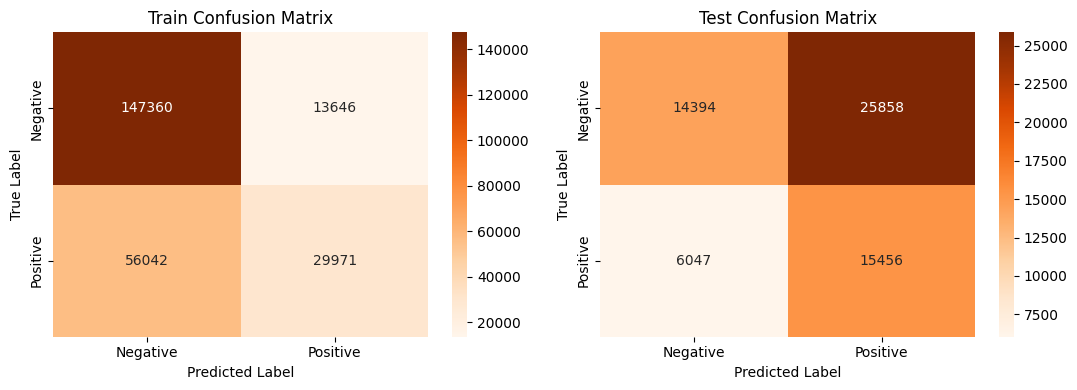


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.724477 | 0.915245 |   0.808764 | 161006        |
| 1            |    0.68714  | 0.348447 |   0.462408 |  86013        |
| accuracy     |    0.717884 | 0.717884 |   0.717884 |      0.717884 |
| macro avg    |    0.705808 | 0.631846 |   0.635586 | 247019        |
| weighted avg |    0.711476 | 0.717884 |   0.688161 | 247019        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.704173 | 0.357597 |   0.474322 | 40252        |
| 1            |    0.37411  | 0.718783 |   0.492096 | 21503        |
| accuracy     |    0.483362 | 0.483362 |   0.483362 |     0.483362 |
| macro avg    |    0.539142 | 0.53819  |   0.483209 | 61755        |
| weighted avg |    0.58

,Logistic regression,Logistic regression tuned,K-Nearest Neighbour,LinearSVM_calibrated,SVM,SVM tuned,Decision Tree,Decision Tree Tuned,Random Forest,XGB,XGB tuned,Naive Bayes,Naive Bayes tuned
Precision Train,0.724873,0.724985,0.794304,0.723867,0.723867,0.722285,1.000000,0.784943,0.999996,0.796937,0.794695,0.695299,0.711476
Precision Test,0.721117,0.721304,0.696323,0.713158,0.713158,0.718735,0.650496,0.424845,0.557647,0.664782,0.803635,0.588217,0.589246
Recall Train,0.731705,0.731770,0.793518,0.731400,0.731400,0.729665,1.000000,0.754800,0.999996,0.767828,0.758508,0.703306,0.717884
Recall Test,0.728540,0.728670,0.709157,0.722600,0.722600,0.726694,0.646474,0.651801,0.642102,0.679022,0.745705,0.482989,0.483362
Accuracy Train,0.731705,0.731770,0.793518,0.731400,0.731400,0.729665,1.000000,0.754800,0.999996,0.767828,0.758508,0.703306,0.717884
Accuracy Test,0.728540,0.728670,0.709157,0.722600,0.722600,0.726694,0.646474,0.651801,0.642102,0.679022,0.745705,0.482989,0.483362
ROC-AUC Train,0.657094,0.657087,0.735386,0.663728,0.663728,0.654930,1.000000,0.659063,0.999994,0.677336,0.661729,0.657262,0.631846
ROC-AUC Test,0.653008,0.653086,0.642623,0.652688,0.652688,0.651137,0.616135,0.500000,0.502719,0.619138,0.637766,0.537374,0.538190
F1 macro Train,0.710598,0.710617,0.782023,0.713539,0.713539,0.708453,1.000000,0.718340,0.999996,0.736470,0.721357,0.697647,0.688161
F1 macro Test,0.706786,0.706882,0.693065,0.703611,0.703611,0.704902,0.648311,0.514402,0.534305,0.667173,0.696608,0.480348,0.480511


In [24]:
# ML Model - 6 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
# Define the hyperparameter grid
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

# Initialize the model
naive = GaussianNB()

# repeated stratified kfold
rskf = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=0)

# Initialize GridSearchCV
GridSearch = GridSearchCV(naive, param_grid, cv=rskf, n_jobs=-1)

# Fit the GridSearchCV to the training data
GridSearch.fit(X_train_scaled, y_train)

# Select the best hyperparameters
best_params = GridSearch.best_params_
print("Best hyperparameters: ", best_params)

# Initiate model with best parameters
nb_model2 = GaussianNB(var_smoothing = best_params['var_smoothing'])

# Visualizing evaluation Metric Score chart
nb2_score = evaluate_model(nb_model2, X_train_scaled, X_test, y_train, y_test)

score['Naive Bayes tuned']= nb2_score
score

# Neural Network


Train ROC AUC: 0.6707195487058575
Test ROC AUC: 0.5799099942325402


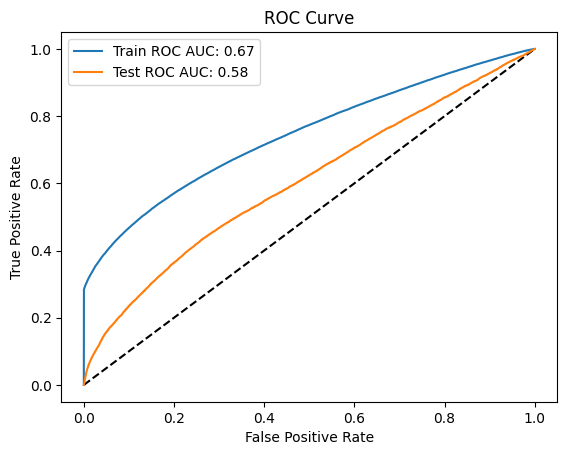


Confusion Matrix:


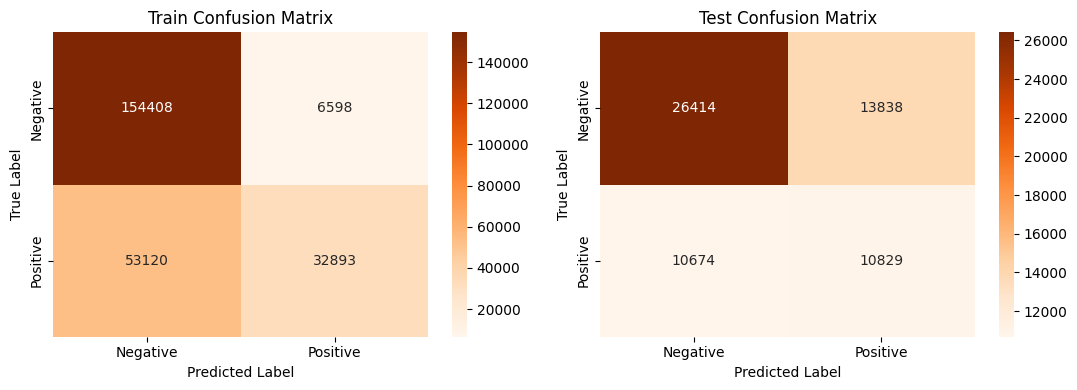


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.744035 | 0.95902  |   0.837958 | 161006        |
| 1            |    0.832924 | 0.382419 |   0.524175 |  86013        |
| accuracy     |    0.758245 | 0.758245 |   0.758245 |      0.758245 |
| macro avg    |    0.788479 | 0.67072  |   0.681066 | 247019        |
| weighted avg |    0.774986 | 0.758245 |   0.728697 | 247019        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.712198 | 0.656216 |   0.683062 | 40252        |
| 1            |    0.439008 | 0.503604 |   0.469092 | 21503        |
| accuracy     |    0.603077 | 0.603077 |   0.603077 |     0.603077 |
| macro avg    |    0.575603 | 0.57991  |   0.576077 | 61755        |
| weighted avg |    0.61

,Logistic regression,Logistic regression tuned,K-Nearest Neighbour,LinearSVM_calibrated,SVM,SVM tuned,Decision Tree,Decision Tree Tuned,Random Forest,XGB,XGB tuned,Naive Bayes,Naive Bayes tuned,Neural Network
Precision Train,0.724873,0.724985,0.794304,0.723867,0.723867,0.722285,1.000000,0.784943,0.999996,0.796937,0.794695,0.695299,0.711476,0.774986
Precision Test,0.721117,0.721304,0.696323,0.713158,0.713158,0.718735,0.650496,0.424845,0.557647,0.664782,0.803635,0.588217,0.589246,0.617074
Recall Train,0.731705,0.731770,0.793518,0.731400,0.731400,0.729665,1.000000,0.754800,0.999996,0.767828,0.758508,0.703306,0.717884,0.758245
Recall Test,0.728540,0.728670,0.709157,0.722600,0.722600,0.726694,0.646474,0.651801,0.642102,0.679022,0.745705,0.482989,0.483362,0.603077
Accuracy Train,0.731705,0.731770,0.793518,0.731400,0.731400,0.729665,1.000000,0.754800,0.999996,0.767828,0.758508,0.703306,0.717884,0.758245
Accuracy Test,0.728540,0.728670,0.709157,0.722600,0.722600,0.726694,0.646474,0.651801,0.642102,0.679022,0.745705,0.482989,0.483362,0.603077
ROC-AUC Train,0.657094,0.657087,0.735386,0.663728,0.663728,0.654930,1.000000,0.659063,0.999994,0.677336,0.661729,0.657262,0.631846,0.670720
ROC-AUC Test,0.653008,0.653086,0.642623,0.652688,0.652688,0.651137,0.616135,0.500000,0.502719,0.619138,0.637766,0.537374,0.538190,0.579910
F1 macro Train,0.710598,0.710617,0.782023,0.713539,0.713539,0.708453,1.000000,0.718340,0.999996,0.736470,0.721357,0.697647,0.688161,0.728697
F1 macro Test,0.706786,0.706882,0.693065,0.703611,0.703611,0.704902,0.648311,0.514402,0.534305,0.667173,0.696608,0.480348,0.480511,0.608558


In [25]:
nn_model = MLPClassifier(random_state=0)
# Visualizing evaluation Metric Score chart
neural_score = evaluate_model(nn_model, X_train_scaled, X_test, y_train, y_test)
# Updated Evaluation metric Score Chart
score['Neural Network'] = neural_score
score

Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Best hyperparameters (Bayesian Optimization): OrderedDict([('alpha', 0.00038554513400070007), ('hidden_layer_sizes', 15)])

Train ROC AUC: 0.6594660471720768
Test ROC AUC: 0.5796755570122617


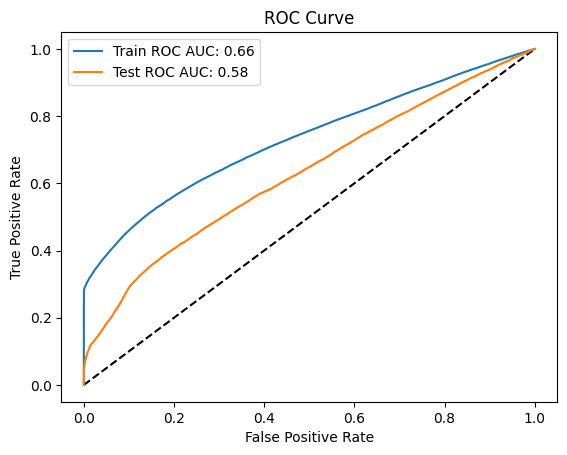


Confusion Matrix:


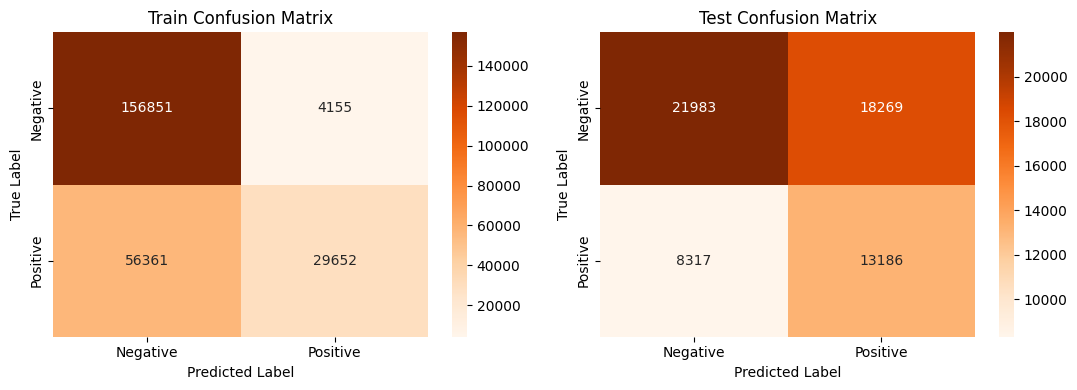


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.735657 | 0.974194 |   0.838287 | 161006        |
| 1            |    0.877096 | 0.344739 |   0.494942 |  86013        |
| accuracy     |    0.755015 | 0.755015 |   0.755015 |      0.755015 |
| macro avg    |    0.806377 | 0.659466 |   0.666615 | 247019        |
| weighted avg |    0.784907 | 0.755015 |   0.718733 | 247019        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.725512 | 0.546134 |   0.623172 | 40252        |
| 1            |    0.419202 | 0.613217 |   0.49798  | 21503        |
| accuracy     |    0.569492 | 0.569492 |   0.569492 |     0.569492 |
| macro avg    |    0.572357 | 0.579676 |   0.560576 | 61755        |
| weighted avg |    0.61

In [26]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

# Define search space for Bayesian optimization
search_spaces = {
    'hidden_layer_sizes': Integer(10, 100),  # This means (10,) to (100,)
    'alpha': Real(1e-5, 1e-2, prior='log-uniform')
}

# Initialize model
mlp_bayes = MLPClassifier(random_state=0, max_iter=1000)

# Cross-validation strategy
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=0)

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=mlp_bayes,
    search_spaces=search_spaces,
    n_iter=10,  # You can increase for better results
    scoring='roc_auc',
    cv=rskf,
    n_jobs=-1,
    random_state=0,
    verbose=1
)

# Fit to SMOTE-balanced training data
bayes_search.fit(X_train_scaled, y_train)

# Get best parameters
best_params_bayes = bayes_search.best_params_
print("Best hyperparameters (Bayesian Optimization):", best_params_bayes)

# Train final model with best params
mlp_bayes_model = MLPClassifier(
    hidden_layer_sizes=(best_params_bayes['hidden_layer_sizes'],),
    alpha=best_params_bayes['alpha'],
    random_state=0,
    max_iter=1000
)
mlp_bayes_model.fit(X_train_scaled, y_train)

# Evaluate and store
neural_bayes_score = evaluate_model(mlp_bayes_model, X_train_scaled, X_test, y_train, y_test)
score['Neural Network BayesSearch'] = neural_bayes_score

# Optional: print all scores
for model, metrics in score.items():
    print(f"{model}: {metrics}")


In [27]:
score['Neural Network tuned']= neural_bayes_score
score

,Logistic regression,Logistic regression tuned,K-Nearest Neighbour,LinearSVM_calibrated,SVM,SVM tuned,Decision Tree,Decision Tree Tuned,Random Forest,XGB,XGB tuned,Naive Bayes,Naive Bayes tuned,Neural Network,Neural Network BayesSearch,Neural Network tuned
Precision Train,0.724873,0.724985,0.794304,0.723867,0.723867,0.722285,1.000000,0.784943,0.999996,0.796937,0.794695,0.695299,0.711476,0.774986,0.784907,0.784907
Precision Test,0.721117,0.721304,0.696323,0.713158,0.713158,0.718735,0.650496,0.424845,0.557647,0.664782,0.803635,0.588217,0.589246,0.617074,0.618855,0.618855
Recall Train,0.731705,0.731770,0.793518,0.731400,0.731400,0.729665,1.000000,0.754800,0.999996,0.767828,0.758508,0.703306,0.717884,0.758245,0.755015,0.755015
Recall Test,0.728540,0.728670,0.709157,0.722600,0.722600,0.726694,0.646474,0.651801,0.642102,0.679022,0.745705,0.482989,0.483362,0.603077,0.569492,0.569492
Accuracy Train,0.731705,0.731770,0.793518,0.731400,0.731400,0.729665,1.000000,0.754800,0.999996,0.767828,0.758508,0.703306,0.717884,0.758245,0.755015,0.755015
Accuracy Test,0.728540,0.728670,0.709157,0.722600,0.722600,0.726694,0.646474,0.651801,0.642102,0.679022,0.745705,0.482989,0.483362,0.603077,0.569492,0.569492
ROC-AUC Train,0.657094,0.657087,0.735386,0.663728,0.663728,0.654930,1.000000,0.659063,0.999994,0.677336,0.661729,0.657262,0.631846,0.670720,0.659466,0.659466
ROC-AUC Test,0.653008,0.653086,0.642623,0.652688,0.652688,0.651137,0.616135,0.500000,0.502719,0.619138,0.637766,0.537374,0.538190,0.579910,0.579676,0.579676
F1 macro Train,0.710598,0.710617,0.782023,0.713539,0.713539,0.708453,1.000000,0.718340,0.999996,0.736470,0.721357,0.697647,0.688161,0.728697,0.718733,0.718733
F1 macro Test,0.706786,0.706882,0.693065,0.703611,0.703611,0.704902,0.648311,0.514402,0.534305,0.667173,0.696608,0.480348,0.480511,0.608558,0.579580,0.579580
